### **Identifying Cell Trajectories with MAGIK**

Cell tracking is a crucial step in the analysis of time-lapse microscopy images. It allows us to study the behavior of individual cells over time, providing insights into cell division, migration, and other dynamic processes. 

This tutorial exemplifies how to use [MAGIK](https://www.nature.com/articles/s42256-022-00595-0) (Motion Analysis Through Graph Inductive Knowledge) to track cells in a variety of datasets from the Cell Tracking Challenge. Furthermore, you will find guidelines on how to apply **MAGIK** to your own data.

#### **1. Loading the Cell Tracking Data**

Let’s begin by choosing a dataset from the Cell Tracking Challenge for analysis. The following datasets are available for this tutorial:

- **BF-C2DL-HSC**
- **BF-C2DL-MuSC**
- **DIC-C2DH-HeLa**
- **Fluo-C2DL-Huh7**
- **Fluo-C2DL-MSC**
- **Fluo-N2DH-SIM+**
- **Fluo-N2DL-HeLa**
- **PhC-C2DH-U373**
- **PhC-C2DL-PSC**

For example, You can download and extract the **DIC-C2DH-HeLa** dataset using the code snippet provided below:

In [6]:
dataset_name = "DIC-C2DH-HeLa"  # Modify this line to change the dataset 

You can download and extract this dataset using the code snippet provided below:

In [7]:
import os
from torchvision.datasets.utils import download_url, _extract_zip

dataset_path = os.path.join(".", "datasets")

if not os.path.exists(os.path.join(dataset_path, dataset_name)):
    url = f"http://data.celltrackingchallenge.net/training-datasets/{dataset_name}.zip"

    download_url(url, ".") # (1)
    _extract_zip(f"{dataset_name}.zip", dataset_path, None) # (2)
    os.remove(f"{dataset_name}.zip") # (3)

This script **(2)** downloads the dataset, **(3)** unzips it into the `dataset_path` directory, and **(4)** remove the downloaded zip file.

The dataset comprises the following subdirectories:
    
```
Name_of_the_dataset
- 01
| - t0000.tif
| - ...
- 01_GT
| - SEG
| | - man_seg0000.tif
| | - ...
| - TRA
| | - man_track.txt
| | - man_track0000.tif
| | - ...
- 01_ST
| - SEG
| | - man_seg0000.tif
| | - ...
- 02
| - t0000.tif
| - ...
- 02_GT
| - SEG
| | - man_seg0000.tif
| | - ...
| - TRA
| | - man_track.txt
| | - man_track0000.tif
| | - ...
- 02_ST
| - SEG
| | - man_seg0000.tif
| | - ...
```

The data consists of two sets of image sequences stored in the `01` and `02` folders. Each set includes segmentation masks in two quality levels: the gold-standard corpus containing human-origin reference annotations as the gold truth (`GT`) and the silver-standard corpus containing computer-origin reference annotations as the silver truth (`ST`). Furthermore, the GT folder has an additional TRA folder that holds ground-truth cell trajectories in the form of both text files and images.

We will use sequence `02` for training and sequence `01` for testing for the majority of the datasets. In both scenarios, we will use the silver-standard segmentation masks, if they are avaliable, to simulate real-world scenarios where the segmentation masks are not perfect.

Each dataset has distinct characteristics, requiring the adjustment of specific parameters to optimize training. The table below highlights the parameters that differ across datasets:

| Dataset           | Connectivity Radius | Window size | Dataset size | Min frame | Dataset to train| Train im path| Train seg path | Train rel path |Test im path| Test seg path | Test rel path | 
|-------------------|---------------------|-------------|--------------|-----------|-----------------|--------------|----------------|----------------|------------|---------------|----------------|
| **BF-C2DL-HSC**   | 0.02                | 20          | 1024         | 1200      | "BF-C2DL-HSC"   | "02"         | "02_ST", "SEG" | "02_GT", "TRA" |"01"        | "01_ST", "SEG"| "01_GT", "TRA" |
| **BF-C2DL-MuSC**  | 0.2                 | 15          | 1024         | 200       | "BF-C2DL-MuSC"  | "02"         | "02_ST", "SEG" | "02_GT", "TRA" |"01"        | "01_ST", "SEG"| "01_GT", "TRA" |
| **DIC-C2DH-HeLa** | 0.2                 | 5           | 512          | 0         | "DIC-C2DH-HeLa" | "02"         | "02_ST", "SEG" | "02_GT", "TRA" |"01"        | "01_ST", "SEG"| "01_GT", "TRA" |
| **Fluo-C2DL-Huh7**| 0.2                 | 5           | 512          | 0         | "Fluo-C2DL-Huh7"| "02"         | "02_GT", "TRA" | "02_GT", "TRA" |"01"        | "01_GT", "TRA"| "01_GT", "TRA" |
| **Fluo-C2DL-MSC** | 0.2                 | 5           | 1024         | 0         | "Fluo-C2DL-MSC" | "02"         | "02_ST", "SEG" | "02_GT", "TRA" |"01"        | "01_ST", "SEG"| "01_GT", "TRA" |
| **Fluo-N2DH-SIM+**| 0.2                 | 5           | 512          | 0         | "BF-C2DL-MuSC"  | "02"         | "02_GT", "SEG" | "02_GT", "TRA" |"01"        | "01_GT", "SEG"| "01_GT", "TRA" |
| **Fluo-N2DL-HeLa**| 0.05                | 20          | 512          | 0         | "Fluo-N2DL-HeLa"| "01"         | "01_ST", "SEG" | "01_GT", "TRA" |"02"        | "02_ST", "SEG"| "02_GT", "TRA" |
| **PhC-C2DH-U373** | 0.2                 | 5           | 512          | 0         | "PhC-C2DH-U373" | "02"         | "02_ST", "SEG" | "02_GT", "TRA" |"01"        | "01_ST", "SEG"| "01_GT", "TRA" |
| **PhC-C2DL-PSC**  | 0.04                | 15          | 1024         | 0         | "PhC-C2DL-PSC"  | "02"         | "02_ST", "SEG" | "02_GT", "TRA" |"01"        | "01_ST", "SEG"| "01_GT", "TRA" |

Although the table above provides the default parameters for each dataset of the Cell Tracking Challenge, it gives an intuition on how to adjust the parameters for your dataset, depending on the dataset size, and cell density, cell dynamics, among other factors.

In [8]:
dataset_parameters = {
    "BF-C2DL-HSC":    {
        "connectivity_radius": 0.02, 
        "window_size": 20, 
        "dataset_size": 1024, 
        "min_frame": 1200, 
        "dataset_to_train": "BF-C2DL-HSC",
        "train_im_path": "02", 
        "train_seg_path": ["02_ST", "SEG"], 
        "train_rel_path": ["02_GT", "TRA"], 
        "test_im_path": "01", 
        "test_seg_path": ["01_ST", "SEG"], 
        "test_rel_path": ["01_GT", "TRA"]
    },
    "BF-C2DL-MuSC":   {
        "connectivity_radius": 0.2,  
        "window_size": 15, 
        "dataset_size": 1024, 
        "min_frame": 200,  
        "dataset_to_train": "BF-C2DL-MuSC",
        "train_im_path": "02", 
        "train_seg_path": ["02_ST", "SEG"], 
        "train_rel_path": ["02_GT", "TRA"], 
        "test_im_path": "01", 
        "test_seg_path": ["01_ST", "SEG"], 
        "test_rel_path": ["01_GT", "TRA"]
    },
    "DIC-C2DH-HeLa":  {
        "connectivity_radius": 0.2,  
        "window_size": 5,  
        "dataset_size": 512,  
        "min_frame": 0,    
        "dataset_to_train": "DIC-C2DH-HeLa",
        "train_im_path": "02", 
        "train_seg_path": ["02_ST", "SEG"], 
        "train_rel_path": ["02_GT", "TRA"], 
        "test_im_path": "01", 
        "test_seg_path": ["01_ST", "SEG"], 
        "test_rel_path": ["01_GT", "TRA"]
    },
    "Fluo-C2DL-Huh7": {
        "connectivity_radius": 0.2,  
        "window_size": 5,  
        "dataset_size": 512,  
        "min_frame": 0,    
        "dataset_to_train": "Fluo-C2DL-Huh7",
        "train_im_path": "02", 
        "train_seg_path": ["02_GT", "TRA"], 
        "train_rel_path": ["02_GT", "TRA"], 
        "test_im_path": "01", 
        "test_seg_path": ["01_GT", "TRA"], 
        "test_rel_path": ["01_GT", "TRA"]
    },
    "Fluo-C2DL-MSC":  {
        "connectivity_radius": 0.2,  
        "window_size": 5,  
        "dataset_size": 1024, 
        "min_frame": 0,    
        "dataset_to_train": "Fluo-C2DL-MSC",
        "train_im_path": "02", 
        "train_seg_path": ["02_ST", "SEG"], 
        "train_rel_path": ["02_GT", "TRA"], 
        "test_im_path": "01", 
        "test_seg_path": ["01_ST", "SEG"], 
        "test_rel_path": ["01_GT", "TRA"]
    },
    "Fluo-N2DH-SIM+": {
        "connectivity_radius": 0.2,  
        "window_size": 5,  
        "dataset_size": 512,  
        "min_frame": 0,    
        "dataset_to_train": "BF-C2DL-MuSC",
        "train_im_path": "02", 
        "train_seg_path": ["02_ST", "SEG"], 
        "train_rel_path": ["02_GT", "TRA"], 
        "test_im_path": "01", 
        "test_seg_path": ["01_GT", "SEG"], 
        "test_rel_path": ["01_GT", "TRA"]
    },
    "Fluo-N2DL-HeLa": {
        "connectivity_radius": 0.05, 
        "window_size": 20, 
        "dataset_size": 512,  
        "min_frame": 0,    
        "dataset_to_train": "Fluo-N2DL-HeLa",
        "train_im_path": "01", 
        "train_seg_path": ["01_ST", "SEG"], 
        "train_rel_path": ["01_GT", "TRA"], 
        "test_im_path": "02", 
        "test_seg_path": ["02_ST", "SEG"], 
        "test_rel_path": ["02_GT", "TRA"]
    },
    "PhC-C2DH-U373":  {
        "connectivity_radius": 0.2,  
        "window_size": 5,  
        "dataset_size": 512,  
        "min_frame": 0,    
        "dataset_to_train": "PhC-C2DH-U373",
        "train_im_path": "02", 
        "train_seg_path": ["02_ST", "SEG"], 
        "train_rel_path": ["02_GT", "TRA"], 
        "test_im_path": "01", 
        "test_seg_path": ["01_ST", "SEG"], 
        "test_rel_path": ["01_GT", "TRA"]
    },
    "PhC-C2DL-PSC":   {
        "connectivity_radius": 0.04, 
        "window_size": 15, 
        "dataset_size": 1024, 
        "min_frame": 0,    
        "dataset_to_train": "PhC-C2DL-PSC",
        "train_im_path": "02", 
        "train_seg_path": ["02_ST", "SEG"], 
        "train_rel_path": ["02_GT", "TRA"], 
        "test_im_path": "01", 
        "test_seg_path": ["01_ST", "SEG"], 
        "test_rel_path": ["01_GT", "TRA"]
    }
}


def load_dataset_config(dataset_name):
    if dataset_name not in dataset_parameters:
        raise ValueError(f"Dataset '{dataset_name}' is not defined.")
    
    config = dataset_parameters[dataset_name]
    print(f"Loaded configuration for {dataset_name}:\n{config}\n")
    return config

config = load_dataset_config(dataset_name)

# Apply parameters
connectivity_radius = config["connectivity_radius"]
window_size = config["window_size"]
dataset_size = config["dataset_size"]
min_frame = config["min_frame"]
dataset_to_train = config["dataset_to_train"]
train_im_path = config["train_im_path"]
train_seg_path = config["train_seg_path"]
train_rel_path = config["train_rel_path"]
test_im_path = config["test_im_path"]
test_seg_path = config["test_seg_path"]
test_rel_path = config["test_rel_path"]


train_dataset_path = os.path.join(".", "datasets")

# Check if the training dataset (dataset_to_train) differs from the test dataset (dataset_name).
# This is useful when the training data is sourced from a different dataset due to insufficient data 
# or suboptimal annotation quality in the original training set.
if not os.path.exists(os.path.join(train_dataset_path, dataset_to_train)):
    
    url = f"http://data.celltrackingchallenge.net/training-datasets/{dataset_to_train}.zip"

    download_url(url, ".")
    _extract_zip(f"{dataset_to_train}.zip", train_dataset_path, None)
    os.remove(f"{dataset_to_train}.zip")


Loaded configuration for DIC-C2DH-HeLa:
{'connectivity_radius': 0.2, 'window_size': 5, 'dataset_size': 512, 'min_frame': 0, 'dataset_to_train': 'DIC-C2DH-HeLa', 'train_im_path': '02', 'train_seg_path': ['02_ST', 'SEG'], 'train_rel_path': ['02_GT', 'TRA'], 'test_im_path': '01', 'test_seg_path': ['01_ST', 'SEG'], 'test_rel_path': ['01_GT', 'TRA']}



Next, we define the paths for the training images and their corresponding segmentation masks:

In [9]:
train_image_path = os.path.join(dataset_path, dataset_to_train, train_im_path)
train_segmentation_path = os.path.join(dataset_path, dataset_to_train, train_seg_path[0], train_seg_path[1])

Note, these paths are specific to the **DIC-C2DH-HeLa** dataset. If you are using a custom dataset, you will need to adjust the paths to match your dataset structure, i.e.,

```python
train_image_path = "path/to/training/images"
train_segmentation_path = "path/to/training/segmentation/masks"
```

The segmentations are expected to be labeled images, where each pixel is assigned a unique cell ID. Each cell in the image should have a distinct ID, while the background should be labeled as 0.

Load the data using the code snippet below:

In [10]:
import glob
import cv2

def load_images(path):
    images = []
    for file in glob.glob(path + "/*.tif"): # (1)
        image = cv2.imread(file, cv2.IMREAD_UNCHANGED) # (2)
        images.append(image) # (3)

    return images

train_images = load_images(train_image_path)
train_segmentations = load_images(train_segmentation_path)

This script **(1)** iterates over each file in the specified directory path containing a `.tif` extension (modify the extension if your images are in a different format), **(2)** reads the image using OpenCV's `cv2.imread()` function with the `IMREAD_UNCHANGED flag` indicating that the image should be loaded without any modification or conversion, and **(3)** appends the loaded image to the `images` list.

Let us visualize some frames from the training image sequence along with their corresponding segmentation mask.

The script below plots a specified number of frames distributed evenly over the training image sequence.

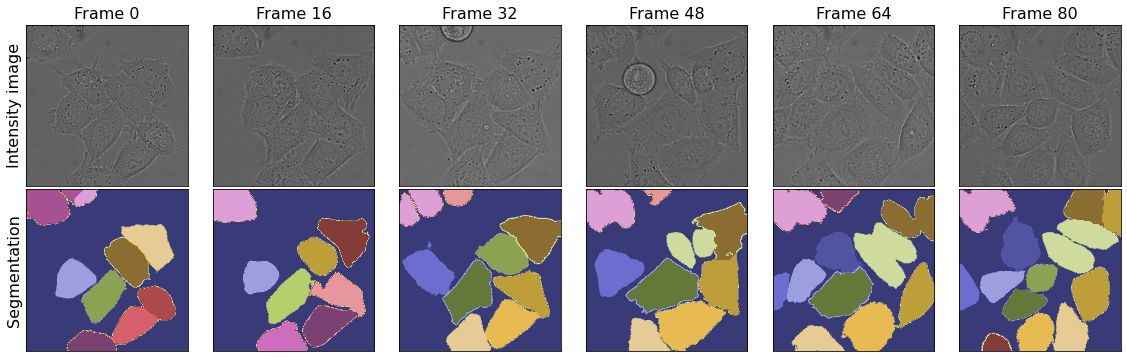

In [11]:
import matplotlib.pyplot as plt

number_of_frames = 5

total_frames = len(train_segmentations) 

plot_interval = total_frames // number_of_frames 
frames_to_plot = [i for i in range(0, total_frames, plot_interval)]

fig, axs = plt.subplots(2, number_of_frames + 1, figsize=(20, 6)) # (5)
fig.patch.set_facecolor('white')

for i, frame in enumerate(frames_to_plot):
    if i == 0:
        axs[0, i].set_ylabel("Intensity image", fontsize=16)
        axs[1, i].set_ylabel("Segmentation", fontsize=16)

    axs[0, i].imshow(train_images[frame], cmap='gray')
    axs[0, i].set_title(f"Frame {frame}", fontsize=16)
    axs[0, i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

    # Plot segmentation
    axs[1, i].imshow(train_segmentations[frame], cmap='tab20b')
    axs[1, i].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.show()

#### **Creating a Graph From Segmented Images**

MAGIK models cell motion and interactions as a directed graph, where nodes represent segmented cells and edges connect spatially close cells across frames.

We will implement the `GraphFromSegmentations` class to generate a graph from the segmented video frames:

In [12]:
import numpy as np
from skimage import measure

import torch
from torch_geometric.data import Data


class GraphFromSegmentations:
    def __init__(self, connectivity_radius, max_frame_distance):
        self.connectivity_radius = connectivity_radius # (1)
        self.max_frame_distance = max_frame_distance # (2)

    def __call__(self, images, segmentations, relation):
        x, node_index_labels, frames = [], [], []
        for frame, (image, segmentation) in enumerate(zip(images, segmentations)): # (3)
            features, index_labels = self.compute_node_features(image, segmentation) # (4)

            x.append(features) # (5)
            node_index_labels.append(index_labels) # (6)
            frames.append([frame] * len(features)) # (7)

        x = np.concatenate(x)
        node_index_labels = np.concatenate(node_index_labels)
        frames = np.concatenate(frames)

        edge_index, edge_attr = self.compute_connectivity(x, frames) # (8)
        edge_ground_truth = self.compute_ground_truth( # (9)
            node_index_labels, edge_index, relation
        )

        edge_index = edge_index.T
        edge_attr = edge_attr[:, None]
        edge_ground_truth = edge_ground_truth[:, None]

        graph = Data( # (10)
            x=torch.tensor(x, dtype=torch.float),
            edge_index=torch.tensor(edge_index, dtype=torch.long),
            edge_attr=torch.tensor(edge_attr, dtype=torch.float),
            distance=torch.tensor(edge_attr, dtype=torch.float),
            frames=torch.tensor(frames, dtype=torch.float),
            y=torch.tensor(edge_ground_truth, dtype=torch.float),
        )

        return graph

    def compute_node_features(self, image, segmentation):
        labels = np.unique(segmentation)

        x, indices = [], []
        for label in labels[1:]:
            mask = segmentation == label
            props = measure.regionprops(mask.astype(np.int32), intensity_image=image)[0]

            centroids = props.centroid / np.array(segmentation.shape)

            x.append([*centroids])
            indices.append(label)

        return x, indices

    def compute_connectivity(self, x, frames):
        positions = x[:, :2]
        distances = np.linalg.norm(positions[:, None] - positions, axis=-1)

        frame_diff = (frames[:, None] - frames) * -1

        mask = (distances < self.connectivity_radius) & ( 
            (frame_diff <= self.max_frame_distance) & (frame_diff > 0)
        )

        edge_index = np.argwhere(mask) 
        edge_attr = distances[mask] 

        return edge_index, edge_attr

    def compute_ground_truth(self, indices, edge_index, relation):
        sender = indices[edge_index[:, 0]] 
        receiver = indices[edge_index[:, 1]]
        self_connections_mask = sender == receiver

        if relation is None:
            return self_connections_mask
        
        relation_indices = relation[:, [-1, 0]] 
        relation_indices = relation_indices[relation_indices[:, 0] != 0]

        relation_mask = np.zeros(len(edge_index), dtype=bool)
        for i, (s, r) in enumerate(zip(sender, receiver)):
            if np.any((relation_indices == [s, r]).all(1)): 
                relation_mask[i] = True

        return self_connections_mask | relation_mask

The `GraphFromSegmentations` class is initialized with two parameters: **(1)** `connectivity_radius` and **(2)** `max_frame_distance`. These parameters play an important role in establishing the spatial and temporal thresholds necessary for determining connectivity between nodes within the graph structure.

In the call method, `GraphFromSegmentations` receives two inputs: the segmented video frames (`segmentations`) and the parent-child relationships between cells (`relation`). **(3)** The method identifies separate objects in each frame of the segmented video data using their index labels. Next, **(4)** it calculates relevant features such as normalized centroids and eccentricity. **(5)** These features are stored in a set called `x`. The algorithm repeats this process for every object in the frame, creating a collection of node features (`x`), **(6)** index labels (`node_index_labels`), and **(7)** their corresponding frame numbers (`frames`), all poised for further processing.

Leveraging the extracted node features, **(8)** `GraphFromSegmentations` proceeds to calculate pairwise distances between the positions of the nodes. Simultaneously, it computes the temporal difference between frames. Based on the specified thresholds (`connectivity_radius` and `max_frame_distance`), it identifies nodes that are both spatially and temporally close. The result is a set of edge indices (`edge_index`) and corresponding distances (`edge_attr`) representing the connectivity between nodes.

Finally, **(9)** the ground-truth edges are computed. The generated graph includes a redundant number of edges with respect to the actual associations between cells. MAGIK aims to prune the redundant edges while retaining the true connections. Therefore, the ground truth for each edge is a binary value indicating whether an edge should connect two detections, i.e., an edge classification problem. `GraphFromSegmentations` defines the ground truth by comparing the node index labels and parent-child relationships. Firstly, it identifies self-connections where sender and receiver nodes have the same node index labels. Next, it explores the cell relationships to find relational connections, such as cell divisions. The ground truths are derived from the combination of self-connections and relational connections. 

**(10)** `GraphFromSegmentations` constructs a PyTorch Data object using node features, edge indices, attributes, distances, frames, and ground truth. This object encapsulates all necessary information for training and testing.

Instantiate the `GraphFromSegmentations` class with a connectivity radius which depends on the dataset and a maximum frame distance of 2 to reconnect cells not detected in consecutive frames.

In [13]:
graph_constructor = GraphFromSegmentations(connectivity_radius=connectivity_radius, max_frame_distance=2)

We now construct the training graph using `graph_constructor`:

In [14]:
train_relation_path = os.path.join(dataset_path, dataset_to_train, train_rel_path[0], train_rel_path[1]) # (1)
train_relation = np.loadtxt(train_relation_path + "/man_track.txt", dtype=int)

train_graph = graph_constructor(train_images, train_segmentations, train_relation)

(1) Loads the man_track.txt file, which defines parent-child relationships between cells. The file follows a comma-separated format:

```
cell_id, start_frame, end_frame, parent_id
```

If `parent_id` is 0, no parent is assigned.

For custom datasets, you must provide a similar file if parent-child relationships exist. Otherwise, set the relation parameter to `None`.

Use the following code to explore the graph data structure:

In [15]:
print("Number of nodes:", len(train_graph.x))
print("Number of edges:", len(train_graph.edge_index[0]))

Number of nodes: 988
Number of edges: 3036


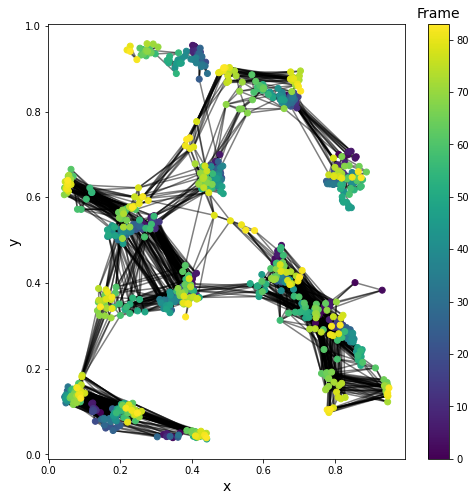

In [16]:
plt.figure(figsize=(8, 8))

for i, j in train_graph.edge_index.T:
    plt.plot(
        [train_graph.x[i, 1], train_graph.x[j, 1]],
        [train_graph.x[i, 0], train_graph.x[j, 0]],
        c="black",
        alpha=0.5,
    )

plt.scatter(
    train_graph.x[:, 1],
    train_graph.x[:, 0],
    c=train_graph.frames,
    cmap="viridis",
    zorder=10,
)
# label colorbar
cb = plt.colorbar()
cb.ax.set_title('Frame', fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)

plt.show()

This scatter plot depicts a graph with nodes represented as dots. The $x$ and $y$ coordinates represent the normalized node centroids. The color of each dot corresponds to the frame number, as shown on the color bar. The black lines on the plot illustrate the edges.

#### **Building a Dataset for Training**


The training dataset consists of a single graph derived from the training video sequence. Although this may initially appear as limited data, it proves to be ample for effectively training the MAGIK model. To address the scarcity of data, we adopt a strategic approach of augmenting the training graph by splitting it into smaller temporal subgraphs.

The `CellTracingDataset` implements this augmentation strategy by dividing the training graph into smaller subgraphs parameterized by the `window_size`parameter:

In [17]:
from torch.utils.data import Dataset


class CellTracingDataset(Dataset):
    def __init__(self, graph, window_size, dataset_size, transform=None, min_frame=0):
        self.graph = graph

        self.window_size = window_size # (1)
        self.dataset_size = dataset_size

        frames, edge_index = graph.frames, graph.edge_index
        self.pair_frames = torch.stack(
            [frames[edge_index[0, :]], frames[edge_index[1, :]]], axis=1
        )
        self.frames = frames
        self.max_frame = frames.max()

        self.transform = transform 

        self.min_frame = min_frame

    def __len__(self):
        return self.dataset_size

    def __getitem__(self, idx):
        frame_idx = np.random.randint(self.window_size + self.min_frame, self.max_frame + 1) # (2)

        start_frame = frame_idx - self.window_size
        node_mask = (self.frames >= start_frame) & (self.frames < frame_idx) # (3)
        x = self.graph.x[node_mask] # (4)

        edge_mask = (self.pair_frames >= start_frame) & (self.pair_frames < frame_idx) # (5)
        edge_mask = edge_mask.all(axis=1) 

        edge_index = self.graph.edge_index[:, edge_mask] # (6)
        edge_index -= edge_index.min() 

        edge_attr = self.graph.edge_attr[edge_mask] # (7)

        # sample ground truth edges
        ground_truth_edges = self.graph.y[edge_mask] # (8)

        graph = Data( # (9)
            x=x,
            edge_index=edge_index,
            edge_attr=edge_attr,
            distance=edge_attr,
            y=ground_truth_edges,
        )

        if self.transform: # (10)
            graph = self.transform(graph)

        return graph

**(1)** The `window_size` parameter determines the number of frames in each subgraph. **(2)** The dataset generates subgraphs by randomly sliding a window across the training graph. The subgraph is constructed by extracting **(3-4)** nodes and **(5-8)** edges within the window. **(9)** The dataset returns the subgraph as a PyTorch Data object. 

To further enhance the training dataset, additional augmentations can be applied to the subgraphs. The `CellTracingDataset` class provides the flexibility to include custom augmentations by specifying the `transform` parameter. 

The following code snippet defines two augmentations: `RandomRotation` and `RandomFlip`.

In [18]:
import torch
import math


class RandomRotation: # (1)
    def __call__(self, graph):
        graph = graph.clone()
        centered_features = graph.x[:, :2] - 0.5

        angle = np.random.rand() * 2 * np.math.pi
        rotation_matrix = torch.tensor(
            [
                [math.cos(angle), -math.sin(angle)],
                [math.sin(angle), math.cos(angle)],
            ]
        )
        rotated_features = torch.matmul(centered_features, rotation_matrix)

        graph.x[:, :2] = rotated_features + 0.5
        return graph
    
class RandomFlip: # (2)
    def __call__(self, graph):
        graph = graph.clone()
        centered_features = graph.x[:, :2] - 0.5

        if np.random.randint(2):
            centered_features[:, 0] *= -1
        
        if np.random.randint(2):
            centered_features[:, 1] *= -1
        
        graph.x[:, :2] = centered_features + 0.5
        return graph

**(1)** The `RandomRotation` augmentation function randomly rotates the positional features of the nodes within the subgraph. 

Likewise, **(2)** the `RandomFlip` augmentation randomly flips the positional features of the nodes along the $x$-axis or $y$-axis.

In [19]:
from torchvision import transforms

train_dataset = CellTracingDataset(
    train_graph,
    window_size=window_size,
    dataset_size=dataset_size, # (1)
    transform=transforms.Compose([RandomRotation(), RandomFlip()]),
    min_frame=min_frame,
)

**(1)** `dataset_size` controls the number of subgraphs generated from the training graph per epoch. 

The training dataset is instantiated with a window size of 5 frames and a dataset size of 512 subgraphs.

#### **Defining the Data Loaders**

Now, we proceed to define the data loaders, which are responsible for feeding the data to the model during training.

In [20]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


#### **Building MAGIK**

The following code snippet defines the [MAGIK](https://www.nature.com/articles/s42256-022-00595-0) model:

In [35]:
from deeplay import GraphToEdgeMAGIK
import torch.nn as nn

model = GraphToEdgeMAGIK([96,] * 4, 1, out_activation=nn.Sigmoid) # (1)

print(model) # (2)

GraphToEdgeMAGIK(
  (encoder): Parallel(
    (0-1): 2 x MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Layer[LazyLinear](out_features=96, bias=True)
          (activation): Layer[Identity]()
        )
      )
    )
  )
  (backbone): MessagePassingNeuralNetwork(
    (blocks): LayerList(
      (0): LearnableDistancewWeighting(init_sigma=0.12, init_beta=4.0)
      (1-4): 4 x TransformPropagateUpdate(
        (transform): Transform(
          (combine): Cat()
          (layer): Layer[LazyLinear](out_features=96)
          (activation): Layer[ReLU]()
        )
        (propagate): WeightedSum()
        (update): Update(
          (combine): Cat()
          (layer): Layer[LazyLinear](out_features=96)
          (activation): Layer[ReLU]()
        )
      )
    )
  )
  (selector): FromDict(edge_attr)
  (pool): Layer[Identity]()
  (head): MultiLayerPerceptron(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_featur

**(1)** Instantiates a simplified version of MAGIK, which is a message-passing neural network. The model has four layers, and each layer contains 96 hidden features. Along with the message-passing layers, the model also includes a node encoder, an edge encoder, and a classification head.  **(2)** Prints the model summary.

MAGIK is similar to message-passing neural networks that we have seen in previous examples. However, the main difference is that MAGIK implements a local attention mechanism that allows the model to concentrate on specific nodes and edges during message passing. This mechanism comes into play when aggregating messages to a node. Each message's contribution has a weight that depends on the distance between the connected nodes through a function with learnable parameters defining a learnable local receptive field. With this mechanism, MAGIK can focus on relevant distance-based features during message passing, which is crucial for cell tracking tasks.

#### **Training MAGIK**

Use the following code snippet to train the model:

In [23]:
from deeplay import BinaryClassifier, Adam, Trainer

classifier = BinaryClassifier(model=model, optimizer=Adam(lr=1e-3))
classifier = classifier.create()

trainer = Trainer(max_epochs=10)
trainer.fit(classifier, train_loader)

c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: otobuf is an invalid version and will not be supported in a future release
  warnings.warn(
c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: 3df76a9e45e3a1d6165e42c565a2f8622f7c1f8c- is an invalid version and will not be supported in a future release
  warnings.warn(
C:\Users\Jesus\AppData\Roaming\Python\Python38\site-packages\lightning\pytorch\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
Missing logger folder: c:\GU\cell_linking_challenge\repo_updated\MAGIK_CellLinkingChallenge\lightning_logs
C:\Users\Jesus\AppData\Roaming\Python\Python38\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:452: A layer with UninitializedParameter was found. Thus, the total number of paramet

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ BCELoss          │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ GraphToEdgeMAGIK │  5.9 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 5.9 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 5.9 K                                                                                                
Total estimated model params size (MB): 0

C:\Users\Jesus\AppData\Roaming\Python\Python38\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Output()

#### **Evaluating MAGIK**

Once the model is trained, we can evaluate its performance on the test dataset. 

We start by loading the test data:

In [42]:
test_image_path = os.path.join(dataset_path, dataset_name, test_im_path)
test_segmentation_path = os.path.join(dataset_path, dataset_name, test_seg_path[0], test_seg_path[1])

test_images = load_images(test_image_path)
test_segmentations = load_images(test_segmentation_path)

If you are using a custom dataset, you will need to adjust the paths to match your dataset structure, i.e.,

```python
test_image_path = "path/to/test/images"
test_segmentation_path = "path/to/test/segmentation/masks"
```

and the corresponding parent-child relationships:

In [43]:
test_relation_path = os.path.join(dataset_path, dataset_name, test_rel_path[0], test_rel_path[1])
test_relation = np.loadtxt(test_relation_path + "/man_track.txt", dtype=int)

We now construct the test graph using `graph_constructor`:

In [44]:
test_graph = graph_constructor(test_images, test_segmentations, test_relation)

In [45]:
print("Number of nodes:", len(test_graph.x))
print("Number of edges:", len(test_graph.edge_index[0]))

Number of nodes: 1104
Number of edges: 3652


After creating the test graph, we can assess the model's performance by calculating the f1-score of the predicted and ground-truth edge classification:

In [46]:
from sklearn.metrics import f1_score

classifier.eval()
pred = classifier(test_graph)
predictions = pred.detach().numpy() > 0.5

ground_truth = test_graph.y

score = f1_score(ground_truth, predictions)
print(f"Test F1 score: {score}")

Test F1 score: 0.9932322053675613


You can expect an f1-score of approximately 0.99 on the test graph, exhibiting the model's ability to accurately predict cell temporal associations.

Note that MAGIK does not output cell trajectories, but a graph structure that shows the connections between cells across frames. To generate cell trajectories, a post-processing algorithm is applied to the predicted graph structure.

The `compute_trajectories` function below implements a simple post-processing algorithm to compute cell trajectories from MAGIK predictions. This might be refined based on edge probability to improve the results, e.g., as done in the file `post.py` in the `\SW\lib` folder. 

In [47]:
import networkx as nx

class compute_trajectories:

    def __call__(self, graph, predictions):
        pruned_edges = self.prune_edges(graph, predictions)

        pruned_graph = nx.Graph()
        pruned_graph.add_edges_from(pruned_edges)

        trajectories = list(nx.connected_components(pruned_graph))

        return trajectories

    def prune_edges(self, graph, predictions):
        pruned_edges = []

        frame_pairs = np.stack(
            [graph.frames[graph.edge_index[0]], graph.frames[graph.edge_index[1]]],
            axis=1,
        )

        senders = np.unique(graph.edge_index[0])
        for sender in senders: 
            sender_mask = graph.edge_index[0] == sender # (1)
            candidate = predictions[sender_mask] == True # (2)

            frame_diff = frame_pairs[sender_mask, 1] - frame_pairs[sender_mask, 0]
            candidates_frame_diff = frame_diff[candidate]

            if not np.any(candidate):
                continue
            else:
                candidate_min_frame_diff = candidates_frame_diff.min()
            
            candidate_edge_index = graph.edge_index[:, sender_mask][ # (3)
                :, candidate & (frame_diff == candidate_min_frame_diff)
            ]
            candidate_edge_index = candidate_edge_index.reshape(-1, 2)

            if len(candidate_edge_index) == 1: # (4)
                pruned_edges.append(tuple(*candidate_edge_index.numpy()))

        return pruned_edges

post_processor = compute_trajectories()

**(1)** The algorithm starts by selecting a node in the first frame ($t=0$) and then links it to other nodes in the following frames, **(2)** using only edges labeled as "linked" by MAGIK. **(3)** If there are no "linked" edges connecting the sender node at time $t$ to any receiver nodes at time $t+1$, the algorithm checks future frames up to a maximum time delay. If no "linked" edges are found within this timeframe, the trajectory ends.

When a sender node has two "linked" edges connecting it to two receiver nodes in a later frame, it's identified as a division. In this case, **(4)** the algorithm creates two new trajectories. This process repeats until all "linked" edges are dealt with.

In [48]:
trajectories = post_processor(test_graph, predictions.squeeze())

Finally, we proceed to visualize the computed cell trajectories on top of the segmented video frames:

In [49]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from skimage import measure
import matplotlib.pyplot as plt

size = test_segmentations[0].shape

fig, ax = plt.subplots(figsize=(8, 8))

list_of_colors = plt.cm.get_cmap("tab20b", len(trajectories))
np.random.shuffle(list_of_colors.colors)

def update(frame):
    ax.clear()
    ax.imshow(test_images[frame], cmap="gray")

    segmentation = test_segmentations[frame]
    labels = np.unique(segmentation)

    for label in labels[1:]:
        contour = measure.find_contours(segmentation == label, 0.5)[0]
        ax.fill(
            contour[:, 1],
            contour[:, 0],
            color="purple",
            alpha=0.2,
            linewidth=6,
        )

    for idx, t in enumerate(trajectories):
        coordinates = test_graph.x[list(t)]
        frames = test_graph.frames[list(t)]

        coordinates_in_frame = coordinates[frames == frame]

        if len(coordinates_in_frame) == 0:
            continue

        ax.scatter(coordinates_in_frame[:, 1] * 512, coordinates_in_frame[:, 0] * 512, color="purple")

        coordinates_previous_frames = coordinates[
                (frames <= frame) & (frames >= frame - 10)
        ]
        f = frames[(frames <= frame) & (frames >= frame - 10)]
        coordinates_previous_frames = coordinates_previous_frames[np.argsort(f[f <= frame])]
        ax.plot(
            coordinates_previous_frames[:, 1] * 512,
            coordinates_previous_frames[:, 0] * 512,
            color="white",
        )

        ax.plot(
            coordinates_in_frame[max(0, frame - 10) : frame, 1] * 512,
            coordinates_in_frame[max(0, frame - 10) : frame, 0] * 512,
            color="red",
        )

    return ax


ani = FuncAnimation(fig, update, frames=len(test_segmentations))

#html_video = HTML(ani.to_jshtml())
html_video = HTML(ani.to_html5_video())

plt.close()
html_video

#### **Saving results**

Save the predicted graph representation using the following code snippet:

In [50]:
if not os.path.exists("results"):
    os.makedirs("results")

predicted_graph = Data()

# Node coordinates
predicted_graph.x = test_graph.x[:, :2]
# Edge index
predicted_graph.edge_index = test_graph.edge_index
# Predictions
predicted_graph.prediction = predictions
# Frames
predicted_graph.frames = test_graph.frames
# Ground truth
predicted_graph.gt = test_graph.y

torch.save(predicted_graph, f"results/predicted_graph_{dataset_name}.pt")

Likewise, the trained model can be saved for future use:

In [51]:
torch.save(model.state_dict(), "results/model_state_dict.pt")

These weights can further be loaded using the following code snippet:

```python
model = GraphToEdgeMAGIK([96,] * 4, 1, out_activation=nn.Sigmoid)
model.load_state_dict(torch.load("results/model_state_dict.pt"))
```
